# Supernova spectrum matching and classification notebook

### Import packages needed and functions called

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functions import (ProcessSpectra, BinSpec, split, 
                       get_classification, dered, get_spec_matches, 
                       target_wavelength_range, plot, get_z_stats)
from glob import glob
from joblib import dump, load
import os
%matplotlib inline

Load the model and the list of classifications for the spectra in the model

In [2]:
# Load the model
model_location = './models/2021-03-04_KNNClassification_model.k=1000.joblib'
clf = load(model_location) 

# load the class list for this model
classlist = np.loadtxt('./PCA_ready/classlist.2021-03-04.txt',dtype='str')
classlist.sort()

# set the list of the spectra for the templates
ref_sne = glob('./spectra/*')
ref_location = './spectra/'

## --User defined--
### Set the input spectrum

In [3]:
# For a single spectrum
specname = 'tns_2021bsr_2021-02-14_NOT_ALFOSC_YSE.txt'

spectrum = f'./for_classification/{specname}'

# set extinction and the redshift, if known
E = False
redshift = 0.049
pad = True

In [31]:
# For multiple spectra in a folder
folder = './for_classification/'

# print the file names in order
spectra = glob(folder +'*')
for idx, i in enumerate(spectra):
    print(idx, os.path.basename(i ) )

# choose the object and set extinction and the redshift, if known
index = 3
E = False
redshift = False

# If padding or clipping is needed, set to True
pad = True
clip = False

# set spectum name ad if necessary pad and deredden
spectrum = spectra[index]

# print the chose spectrum for classification
print(f'\nclassifying {os.path.basename(spectrum) }')

0 2016P_2457408.64423468_LT_SPRAT_None.txt
1 AT2018hcr_20181015.w.txt
2 SN2018gsk_20180922.txt
3 SN2018hna_20181129.txt

classifying SN2018hna_20181129.txt


# Get the best match and the scores for all the matches

### To get the classification matches, call the _get_classification_ function with the following arguments

best_match, indices, scores = get_classification( spectrum location, model, E, pad)

-- _spectrum location_ is a string of the spectrum location.

-- _model_ is the model imported earlier, usually just called clf.

-- _E_ is either a float or False. If omitted, _E_ = False.

-- _pad_ is a boolean set to False by default and pads out spectra that are shorter than _target_wavelength_range_

In [32]:
best_match, indices, scores = get_classification(spectrum, clf, E=E, pad=pad, clip=clip)
best_match_properties = split(best_match)[0]
best_match_properties
print(f'The best match is {best_match_properties[0]} {best_match_properties[1]} (t = {best_match_properties[3]} d) at z = {best_match_properties[2]}')

The best match is II SN2004et (t = 56.96 d) at z = 0.002


### Sort all the matches by score then return them in a list

In [33]:
sorted_scores, sorted_idxs = zip(*list(sorted(zip(scores,indices), reverse=True)))

a  = get_spec_matches(idxs = sorted_idxs, z = redshift, classlist = classlist )
types, sne, zs, epochs, all_specs = zip(*a)

# list the top 15 matches
a[:15]

[('II', 'SN2004et', 0.002, 56.96, 'II_SN2004et_56.96_.txt'),
 ('II', 'SN2004et', 0.004, 56.96, 'II_SN2004et_56.96_.txt'),
 ('II', 'SN2013ej', 0.002, 56.38, 'II_SN2013ej_56.38_.txt'),
 ('II', 'SN2013ej', 0.004, 56.38, 'II_SN2013ej_56.38_.txt'),
 ('II', 'SN2004et', 0.004, 38.79, 'II_SN2004et_38.79_.txt'),
 ('II', 'SN2004et', 0.004, 48.78, 'II_SN2004et_48.78_.txt'),
 ('II', 'SN2004et', 0.002, 38.79, 'II_SN2004et_38.79_.txt'),
 ('II', 'SN2004et', 0.002, 48.78, 'II_SN2004et_48.78_.txt'),
 ('II', 'SN2004et', 0.006, 38.79, 'II_SN2004et_38.79_.txt'),
 ('II', 'SN2004et', 0.006, 56.96, 'II_SN2004et_56.96_.txt'),
 ('II', 'SN2004et', 0.006, 48.78, 'II_SN2004et_48.78_.txt'),
 ('II', 'SN2013ej', 0.006, 56.38, 'II_SN2013ej_56.38_.txt'),
 ('II', 'SN2004et', 0.006, 25.81, 'II_SN2004et_25.81_.txt'),
 ('II', 'SN2004et', 0.004, 25.81, 'II_SN2004et_25.81_.txt'),
 ('II', 'SN2004et', 0.002, 61.76, 'II_SN2004et_61.76_.txt')]

## Plot the best 15 matches

Top 15 matches to SN2018hna_20181129.txt


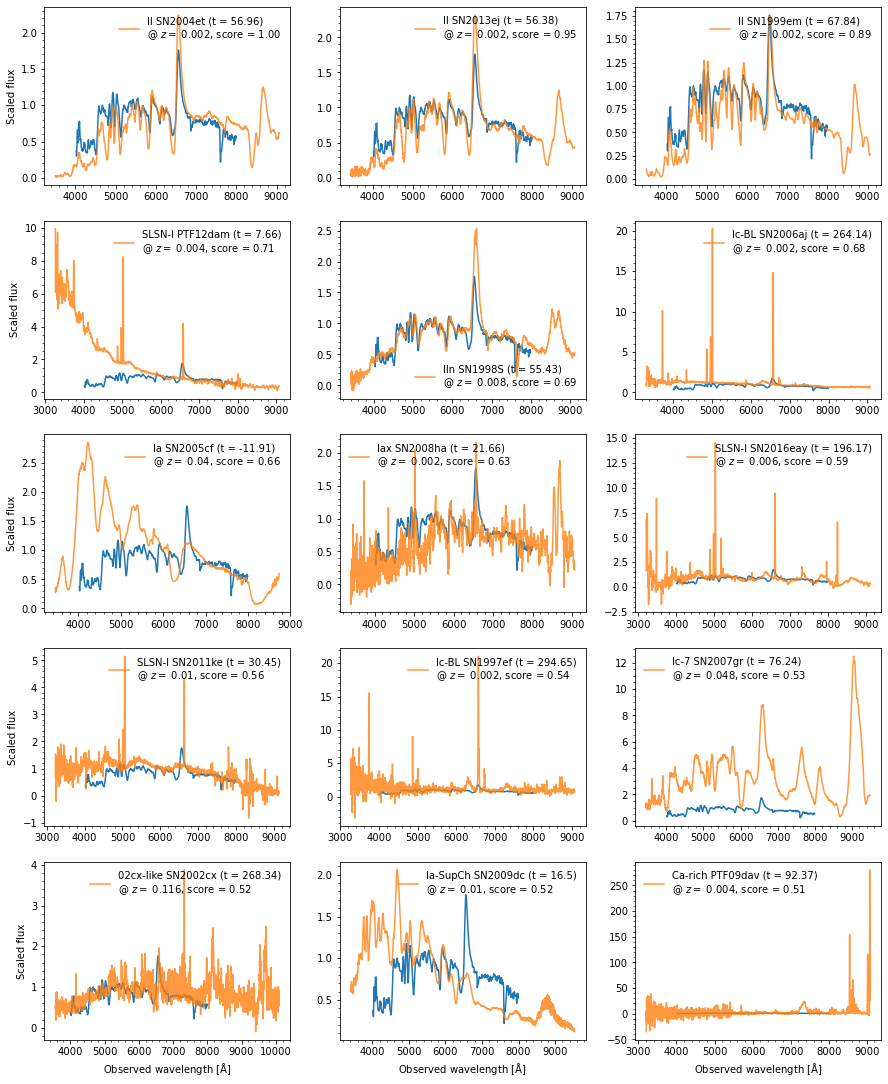

In [34]:
plot(spectrum, types, sne, zs, epochs, all_specs, sorted_scores, E=E, i=15, scaling=6000, clip=clip)

# spectrum match plot saves to the location of the spectrum
#plt.savefig(spectrum+'.pdf', bbox_inches='tight')

## Plot the redshift distributions
The first selects on SN type, be careful with this as although the bins components are weighted according to score
having a lot in one bin with a marginally lower score than the best fit gives a shifted average e.g., the sampling is not uniform!

### First from the best match object

SN2007gr z = 0.055 +-0.010 (std not weighted)


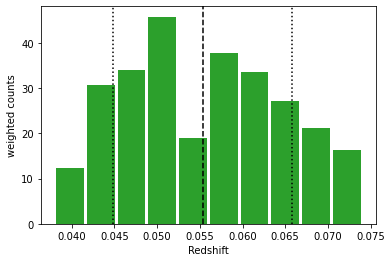

In [26]:
sn = sne[0]
z_stats = get_z_stats(sne, zs, types, sorted_scores, get_sn=sn)
print(f'{sn} z = {z_stats[0][1]:.3f} +-{z_stats[0][2]:.3f} (std not weighted)'  )

### Next from a selected SN type

z = 0.055 +-0.010 (std not weighted)


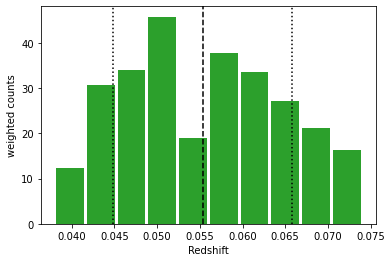

In [28]:
z_stats = get_z_stats(sne, zs, types, sorted_scores, get_type = 'Ic-7')
print(f'z = {z_stats[0][1]:.3f} +-{z_stats[0][2]:.3f} (std not weighted)'  )

### Plot all the redshifts and phases

Text(0.5, 0, 'Redshift')

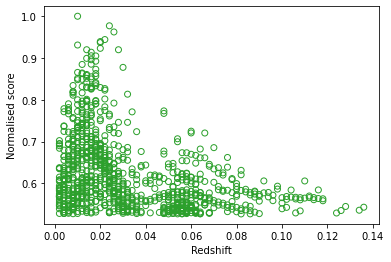

In [11]:
plt.scatter( zs, sorted_scores / max(sorted_scores), facecolor = 'none', color = 'tab:green')
plt.ylabel('Normalised score')
plt.xlabel('Redshift')

Text(0.5, 0, 'Epoch [days]')

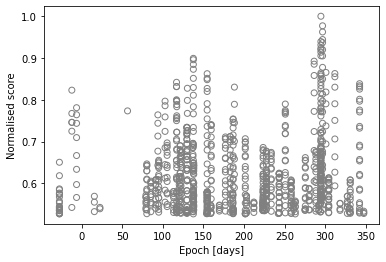

In [12]:
plt.scatter(epochs, sorted_scores / max(sorted_scores), facecolor = 'none', color = 'grey')
plt.ylabel('Normalised score')
plt.xlabel('Epoch [days]')

The same again but for an individual SN. Again the bin components are weighted according to score. This should be a little better than filtering on SN types

## Plot individual SN matches.
Simply define a part of the SN name to include in the search

In [13]:
# Quickly show the unique types and objects
print(set(types), set(sne))

{'Ia', 'Ic-6', 'Ib', 'Ic-BL', 'Ibc', 'IIb', 'SLSN-I', '02cx-like', 'Ic-7', 'IIn', 'Iax', 'Ia-CSM', 'II'} {'SN1987A', 'SN1998S', 'SN2002cx', 'SN2009jf', 'SN2008ha', 'SN1993J', 'SN2012ca', 'PTF12dam', 'SN1998bw', 'SN1999em', 'SN2004aw', 'SN2004et', 'SN1997ef', 'SN2005cf', 'SN2013ge', 'SN2002ap', 'SN2011hs', 'SN2011bm', 'SN2013ej', 'SN2007gr'}


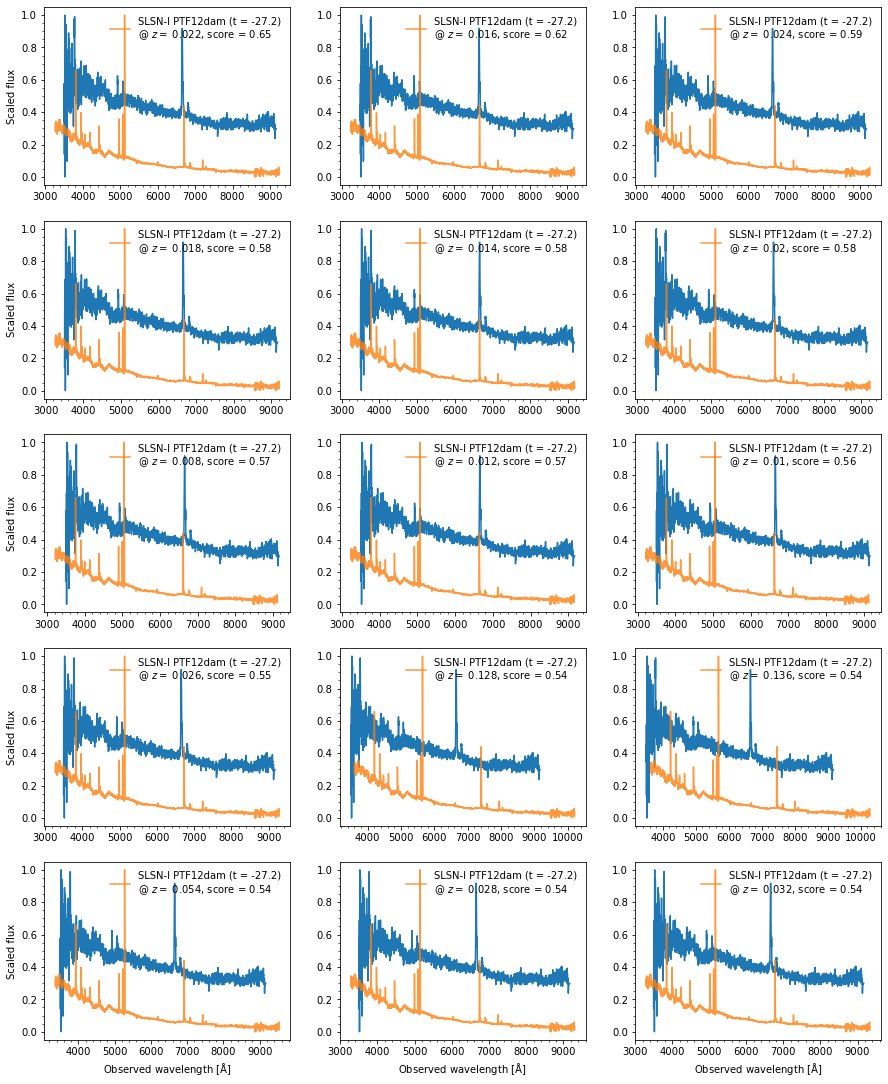

In [14]:
x , y = np.loadtxt(spectrum, usecols = (0,1) ,unpack= True )

if E:
    y = dered(x, y, 3.1, E)

m=1/(max(y)-min(y))
con=-m*min(y)    
y = np.array([m*d+con for d in y])

# need a rising index
n= 0

plt.figure(figsize = (15,19))
for i, spec in enumerate(all_specs):
    if '12dam' in spec and n < 15: 
        
        plt.subplot(5,3, n + 1)
        plt.plot(x, y)
    
        x_, y_ = np.loadtxt(ref_location + spec, unpack = True)
    
        x_ = x_ * (1 + zs[i])
    
        m = 1 / (max(y_) - min(y_))
        con = -m * min(y_)    
        y_ = np.array([m*d+con for d in y_])
    
        fit_score = sorted_scores[i] / max(sorted_scores)
        plt.plot(x_, y_, label = f'{types[i]} {sne[i]} (t = {epochs[i]})\n@ $z=$ {zs[i]}, score = {fit_score:.2f}', alpha = 0.8)

        plt.legend(frameon = False)
        plt.minorticks_on()
        
        # this messes up if the limit of n changes
        if n in  [0, 3, 6, 9, 12]:
            plt.ylabel('Scaled flux')
        if n in [14, 13 ,12]:
            plt.xlabel('Observed wavelength [$\mathrm{\AA}$]')
        #plt.show()
        n+=1
#plt.savefig(f'{spectrum}.pdf')

## If you need to quickly match some galaxy lines

(0.0, 1.0)

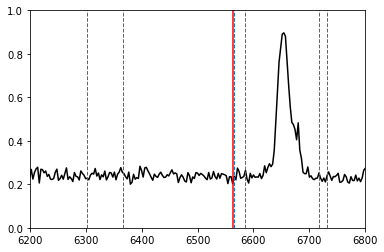

In [19]:
x, y = np.loadtxt(spectrum, unpack=True)
x = x / 1.00
y = y/ y.max()
plt.plot(x,y, color = 'k')

lines, *_ = np.loadtxt('./GalaxyLinesSDSS.txt', unpack = True, dtype = 'str', delimiter='\t')

for line in lines:
    plt.axvline(x = float(line), linestyle = 'dashed', lw = 1)

plt.axvline(x = 6563, color='red')
# plt.axvline(x = 4861)
# plt.axvline(x = 4340)
plt.xlim(6200, 6800)
plt.ylim(0,1)

In [20]:
lines

array(['4072.3', '4102.89', '4341.68', '4364.436', '4862.68', '4932.603',
       '4960.295', '5008.240', '6302.046', '5890', '6365.536', '6564.61',
       '6585.27', '6718.29', '6732.67'], dtype='<U8')